# Wage Pressure Model

## V2.12
    1. For ChangeMeasure and DifferenceMeasure, deal with four cases separately and carefully.
    2. Use hieararchy clustering with 7 clusters.

### V2.11
    1. Use +/-1, +/-3, +/-5 and 0 to quantify the Score changes
    2. Get the mean from latest date for each column, and then scale the score change by different to the mean value.
    3. Use ['CurrentStaffingScore', 'TurnoverScore', 'RecruitingScore',
         'UnemploymentScore', 'KohlstoCountyCompScore', 'CountyScore',
        'AcceptanceRateScore','ApplicantFlowScore']
    4. Use hierarchy clustering  with “from sklearn.cluster import AgglomerativeClustering”

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re
import math
%matplotlib inline

## Read in Dataset

In [2]:
df = pd.read_csv('2017 Wage Pressure Model_example.csv')
location = pd.read_csv('Store_location_m.csv')

def getZip(x):
    
    if len(x) <= 1:
        return ''
    elif len(x) < 5:
        return '0' + str(x)
    else:
        return str(x[:5])

location['zip'] = location['PSTL_CDE'].map(lambda x: getZip(x))
location = location.rename(columns={'EI_LOC_ID':'Location'})

In [3]:
# location.zip.tolist()

### Rename column names to just include [a-zA-Z].

In [4]:
names = df.columns.tolist()
new_names = []
for i in names:
    t = re.findall(r'[a-zA-Z]+', i)
    new_names.append(''.join(t))
    
for i,j in zip(names, new_names):
    df.rename(columns={i:j}, inplace=True)

In [5]:
df_saved = df.copy(deep=True)
changecolumns = ['CurrentStaffingScore', 'TurnoverScore', 'RecruitingScore',
         'UnemploymentScore', 'KohlstoCountyCompScore', 'CountyScore',
        'AcceptanceRateScore','ApplicantFlowScore']
df = df[['Location','EFFDT'] + changecolumns]

In [6]:
df.isnull().sum()

Location                    0
EFFDT                       0
CurrentStaffingScore        1
TurnoverScore               2
RecruitingScore           103
UnemploymentScore          66
KohlstoCountyCompScore     68
CountyScore                68
AcceptanceRateScore       100
ApplicantFlowScore        103
dtype: int64

In [7]:
df4_saved = df_saved[df_saved['EFFDT'] == '1/27/18'].copy(deep=True)
df = df.dropna()

In [8]:
df.notnull().sum()

Location                  4489
EFFDT                     4489
CurrentStaffingScore      4489
TurnoverScore             4489
RecruitingScore           4489
UnemploymentScore         4489
KohlstoCountyCompScore    4489
CountyScore               4489
AcceptanceRateScore       4489
ApplicantFlowScore        4489
dtype: int64

### Separate into four DataFrames according to EFFDT and join them back together. 

In [9]:
df1 = df[df['EFFDT'] == '4/1/17'].copy(deep=True)
df2 = df[df['EFFDT'] == '7/29/17'].copy(deep=True)
df3 = df[df['EFFDT'] == '10/28/17'].copy(deep=True)
df4 = df[df['EFFDT'] == '1/27/18'].copy(deep=True)

In [10]:
for i in changecolumns:
    df1.rename(columns={i:i+'1'}, inplace=True)
    df2.rename(columns={i:i+'2'}, inplace=True)
    df3.rename(columns={i:i+'3'}, inplace=True)
    
df1 = df1[['Location'] + [i+'1' for i in changecolumns]]
df2 = df2[['Location'] + [i+'2' for i in changecolumns]]
df3 = df3[['Location'] + [i+'3' for i in changecolumns]]
df4 = df4[['Location'] + changecolumns]

In [11]:
df4 = df4.join(df1.set_index('Location'), on='Location')
df4 = df4.join(df2.set_index('Location'), on='Location')
df4 = df4.join(df3.set_index('Location'), on='Location')

In [12]:
df4 = df4.dropna()

In [13]:
# df4.notnull().sum()

### Get ChangeMeasure and DifferenceMeasure. 

In [14]:
def measureScore(*x):
    
    s = 0
    
    s += 1 if x[2] > x[1] else -1 if x[2] < x[1] else 0
    s += 3 if x[3] > x[2] else -3 if x[3] < x[2] else 0 
    s += 5 if x[0] > x[3] else -5 if x[0] < x[3] else 0
    
    return s
    
for i in changecolumns:
    df4[i+'Measure'] = df4[[i, i+'1', i+'2', i+'3']].apply(lambda x: measureScore(*x), axis=1) 

In [15]:
# df4.head()

In [16]:
df_mean = {}
for i in changecolumns:
    df_mean[i] = int(df4[i].mean()*10) / 10

In [17]:
df_mean

{'AcceptanceRateScore': 2.5,
 'ApplicantFlowScore': 1.9,
 'CountyScore': 3.7,
 'CurrentStaffingScore': 1.1,
 'KohlstoCountyCompScore': 3.4,
 'RecruitingScore': 2.3,
 'TurnoverScore': 2.7,
 'UnemploymentScore': 4.1}

In [18]:
def scaleScore(x1, x2, avg):
    
    diff = x2 - avg
    # Get worse and Worse than Avg.
    if x1 >= 0 and diff >= 0:
        return x1 * (diff + 1)
    
    # Get worse and Better than Avg.
    elif x1 >= 0 and diff < 0:
        diff = -1 * diff 
        return x1 * diff
    
    # Get better and Worse than Avg.
    elif x1 < 0 and diff >= 0:
        return x1 * diff
    
    # Get better and Better than Avg.
    elif x1 < 0 and diff < 0:
        diff = -1 * diff
        return x1 * (diff + 1)

for i in changecolumns:
    df4[i+'Scale'] = df4[[i+'Measure', i]].apply(lambda x: scaleScore(x1 = x[0], x2 = x[1], avg = df_mean[i]), axis=1)

In [19]:
df4 = df4[['Location'] + [i + 'Measure' for i in changecolumns] + [i + 'Scale' for i in changecolumns]]

In [20]:
# df4.dtypes

In [21]:
print('CurrentStaffingScoreScale range is [%5.2f, %5.2f].'%
      (min(df4['CurrentStaffingScoreScale'].unique()), max(df4['CurrentStaffingScoreScale'].unique())))
print('TurnoverScoreScale min range is [%5.2f, %5.2f].'%
      (min(df4['TurnoverScoreScale'].unique()), max(df4['TurnoverScoreScale'].unique())))

CurrentStaffingScoreScale range is [-14.50, 35.10].
TurnoverScoreScale min range is [-24.30, 26.40].


In [22]:
from sklearn.cluster import AgglomerativeClustering

X = df4[[i+'Scale' for i in ['CurrentStaffingScore','TurnoverScore']]]
x_p = []
y_p = []
for ncenter in [8]:
    ward = AgglomerativeClustering(n_clusters=ncenter).fit(X)
    predictions = ward.labels_
    print('The numbre of leaves for %d clusters is %8.2f.'%(ncenter, ward.n_leaves_))
    x_p.append(ncenter)
    y_p.append(ward.n_leaves_)
    df4 = df4.assign(prediction=list(predictions))
    cluster_2d = df4.join(df4_saved.set_index('Location'), on='Location')

The numbre of leaves for 8 clusters is  1046.00.


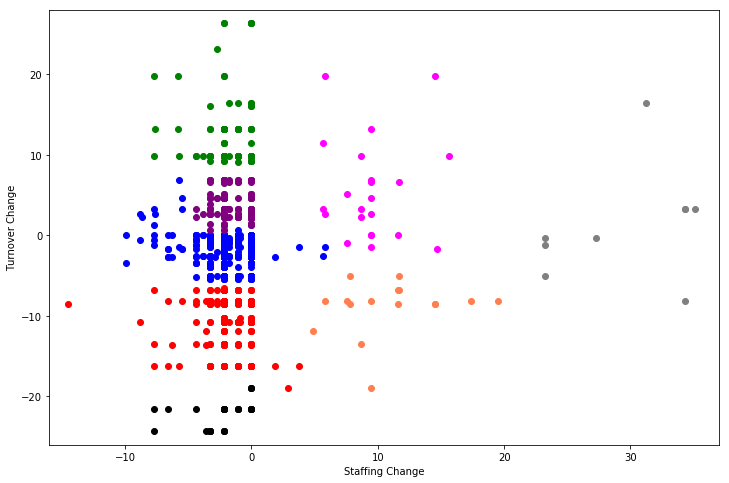

In [23]:
fig = plt.figure(figsize=(12,8))

ax = plt.subplot(111)
n_c = 1
n_list = [0,1,2,3,4,5,6,7]
c_list = ['red','blue','green','fuchsia','purple','black','grey','coral']

# n_list = [3]
# c_list = ['fuchsia']

for n_n, n_c in zip(n_list, c_list):
    ax.scatter(df4[df4['prediction']==n_n]['CurrentStaffingScoreScale'],
               df4[df4['prediction']==n_n]['TurnoverScoreScale'], color=n_c)

ax.set_xlabel('Staffing Change')
ax.set_ylabel('Turnover Change')
ax.set_xlim((-16, 37))
ax.set_ylim((-26,28))
plt.savefig('./V2.12 5 Clusters/Hierarchy_cluster_V2.12_2D.png')

In [24]:
cluster_2d[cluster_2d['prediction'].isin([3])].to_csv('./V2.12 5 Clusters/Hierarch_cluster_V2.12_2D_Cluster3.csv')

In [25]:
# Print out stores.

t_l = df4[df4['CurrentStaffingScoreScale'] < -14]['Location'].tolist()
df4_saved[df4_saved['Location'].isin(t_l)][['Location', 'LocationName']]

,Location,LocationName
4052,711,South Burlington


(array([   1.,    0.,    6.,   16.,   28.,   19.,    0.,   40.,   20.,
         483.,  108.,   75.,   76.,   64.,   36.,    0.,   13.,   19.,
          13.,   29.]),
 array([-15.2, -13.6, -12. , -10.4,  -8.8,  -7.2,  -5.6,  -4. ,  -2.4,
         -0.8,   0.8,   2.4,   4. ,   5.6,   7.2,   8.8,  10.4,  12. ,
         13.6,  15.2,  16.8]),
 <a list of 20 Patch objects>)

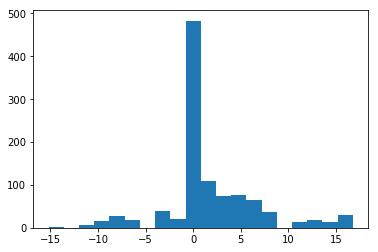

In [26]:
plt.hist(df4['ApplicantFlowScoreScale'], bins=20)

(array([   1.,    0.,    6.,   28.,    0.,   61.,   67.,  165.,   80.,
           0.,  205.,   96.,   46.,  139.,    0.,   45.,   46.,   19.,
          13.,   29.]),
 array([-8. , -7.2, -6.4, -5.6, -4.8, -4. , -3.2, -2.4, -1.6, -0.8,  0. ,
         0.8,  1.6,  2.4,  3.2,  4. ,  4.8,  5.6,  6.4,  7.2,  8. ]),
 <a list of 20 Patch objects>)

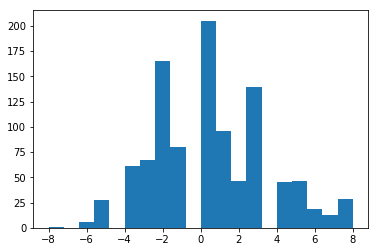

In [27]:
plt.hist(df4['ApplicantFlowScoreMeasure'], bins=20)

In [28]:
for i in changecolumns:
    print('%s range is [%5.2f, %5.2f].'%
      (i, min(df4[i + 'Scale'].unique()), max(df4[i + 'Scale'].unique())))

CurrentStaffingScore range is [-14.50, 35.10].
TurnoverScore range is [-24.30, 26.40].
RecruitingScore range is [-17.10, 15.30].
UnemploymentScore range is [-21.70, 15.20].
KohlstoCountyCompScore range is [-10.20,  7.80].
CountyScore range is [-18.90, 18.40].
AcceptanceRateScore range is [-10.00, 17.50].
ApplicantFlowScore range is [-15.20, 16.80].


In [29]:
from sklearn.cluster import AgglomerativeClustering

X = df4[[i+'Scale' for i in changecolumns]]
x_p = []
y_p = []
for ncenter in [7]:
    ward = AgglomerativeClustering(n_clusters=ncenter).fit(X)
    predictions = ward.labels_
    print('The numbre of leaves for %d clusters is %8.2f.'%(ncenter, ward.n_leaves_))
    x_p.append(ncenter)
    y_p.append(ward.n_leaves_)
    df4 = df4.assign(prediction=list(predictions))
    result = df4.join(df4_saved.set_index('Location'), on='Location')
    # file = 'Hierarchy_' + str(ncenter) + '_clusters.csv'
    # result.to_csv(file)
    
# plt.plot(x_p, y_p)

The numbre of leaves for 7 clusters is  1046.00.


In [30]:
result = result.join(location[['Location','zip']].set_index('Location'), on='Location')
result.to_csv('./V2.12 5 Clusters/Hierarchy_7_clusters_v2.12.csv')

In [31]:
t = result[result['prediction'] == 0][['Location','zip']]
t.to_csv('./V2.12 5 Clusters/Hierarchy_7_clusters_v2.12_0_zip.csv')

In [32]:
# result.columns

In [33]:
if False:
    from sklearn.cluster import KMeans

    X = df4[[i+'Measure' for i in changecolumns]]
    x_p = []
    y_p = []
    for ncenter in [2,3,4,5]:
        kmeans = KMeans(n_clusters=ncenter, random_state=0).fit(X)
        predictions = kmeans.labels_
        print('The inertia for %d clusters is %8.2f.'%(ncenter, kmeans.inertia_))
        x_p.append(ncenter)
        y_p.append(kmeans.inertia_)
        df4 = df4.assign(prediction=list(predictions))
        result = df4.join(df4_saved.set_index('Location'), on='Location')
        # file = 'K_means_' + str(ncenter) + '_clusters.csv'
        # result.to_csv(file)
    
    plt.plot(x_p, y_p)

In [34]:
if False:
    from sklearn.cluster import DBSCAN

    X = df4[[i+'Measure' for i in changecolumns]]
    x_p = []
    y_p = []
    for x_eps in [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
        db = DBSCAN(eps=x_eps, min_samples=10).fit(X)
        predictions = db.labels_
        x_p.append(x_eps)
        y_p.append(len(set(predictions)))
        df4 = df4.assign(prediction=list(predictions))
        db_result = df4[['Location', 'prediction']].join(df4_saved.set_index('Location'), on='Location')
        # file = 'DBSCAN_' + str(x_eps) + '_clustering.csv'
        # db_result.to_csv(file)

    plt.plot(x_p, y_p)

### AgglomerativeClustering Analyze Results

In [35]:
ddff = pd.read_csv('./V2.12 5 Clusters/Hierarchy_7_clusters_v2.12.csv')

In [36]:
ddff = ddff[['Location', 'prediction',
       'CurrentStaffingScoreMeasure', 'TurnoverScoreMeasure',
       'RecruitingScoreMeasure', 'UnemploymentScoreMeasure',
       'KohlstoCountyCompScoreMeasure', 'CountyScoreMeasure',
       'AcceptanceRateScoreMeasure', 'ApplicantFlowScoreMeasure']]

In [37]:
names = ['CurrentStaffingScoreMeasure', 'TurnoverScoreMeasure',
       'RecruitingScoreMeasure', 'UnemploymentScoreMeasure',
       'KohlstoCountyCompScoreMeasure', 'CountyScoreMeasure',
       'AcceptanceRateScoreMeasure', 'ApplicantFlowScoreMeasure']
d = {}
for i_n in names:
    d[i_n] = []
    for i_v in [0,1,2,3,4,5,6]:
        d[i_n].append(len(ddff[(ddff['prediction'] == i_v) & (ddff[i_n] > 1)]) / len(ddff[ddff['prediction'] == i_v]))

In [38]:
cluster_feature = pd.DataFrame(d)

In [39]:
cluster_feature.to_csv('./V2.12 5 Clusters/Hierarchy_clustering_v2.12_feature.csv')

In [40]:
result.columns

Index(['Location', 'CurrentStaffingScoreMeasure', 'TurnoverScoreMeasure',
       'RecruitingScoreMeasure', 'UnemploymentScoreMeasure',
       'KohlstoCountyCompScoreMeasure', 'CountyScoreMeasure',
       'AcceptanceRateScoreMeasure', 'ApplicantFlowScoreMeasure',
       'CurrentStaffingScoreScale', 'TurnoverScoreScale',
       'RecruitingScoreScale', 'UnemploymentScoreScale',
       'KohlstoCountyCompScoreScale', 'CountyScoreScale',
       'AcceptanceRateScoreScale', 'ApplicantFlowScoreScale', 'prediction',
       'LocationName', 'DistrictNumber', 'RegionNumber', 'TerrNum', 'EFFDT',
       'CurrentStartingRate', 'StaffingLevel', 'CurrentStaffingLevel',
       'YTDAverageStaffingLevel', 'CurrentStaffingScore', 'YTDStaffingScore',
       'TotalStaffingScore', 'LYTurn', 'YTDTurn', 'YOYTurnVariance',
       'TurnoverScore', 'UnemploymentScore', 'KohlstoCountyCompScore',
       'CountyScore', 'ApplicantFlow', 'AcceptanceRate', 'AcceptanceRateScore',
       'ApplicantFlowScore', 'RecruitingSc

In [41]:
feature = 'CurrentStaffingScoreScale'
print("%s range is [%5.2f, %5.2f]."%(feature, 
                                     min(result[feature].unique().tolist()), max(result[feature].unique().tolist())))

CurrentStaffingScoreScale range is [-14.50, 35.10].


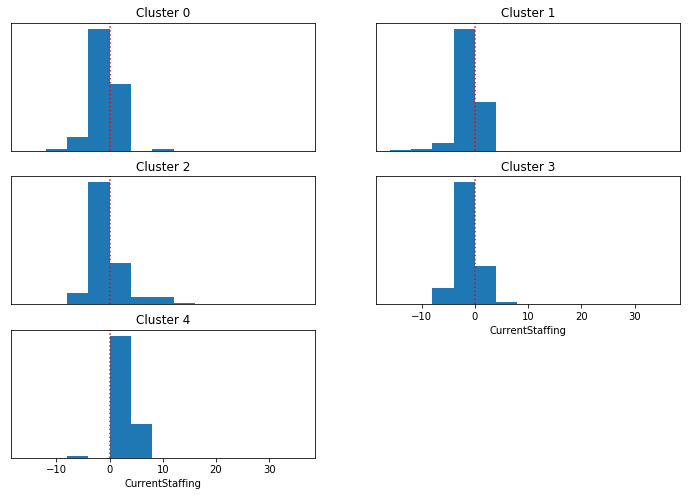

In [42]:
fig = plt.figure(figsize=(12,8))

label = 'CurrentStaffing'
# ApplicantFlow
# a_bins = [-6,-4,-2,0,2,4,6,8,10,12,14,16]

# Recruiting
# a_bins= [-3,-1,1,3,5,7,9,11,13,15]

# AcceptanceRate
# a_bins = [-2,0,2,4,6,8,10,12,14,16,18]

# CurrentStaffing
a_bins = [-16,-12,-8,-4,0,4,8,12,16,20,24,28,32,36]

ax = fig.add_subplot(321)
ax.hist(result[result['prediction'] == 0][feature], bins=a_bins)
ax.set_title('Cluster 0')
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.axvline(x=0, color='red', linestyle=':')

ax = fig.add_subplot(322)
ax.hist(result[result['prediction'] == 1][feature], bins=a_bins)
ax.set_title('Cluster 1')
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.axvline(x=0, color='red', linestyle=':')

ax = fig.add_subplot(323)
ax.hist(result[result['prediction'] == 2][feature], bins=a_bins)
ax.set_title('Cluster 2')
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.axvline(x=0, color='red', linestyle=':')

ax = fig.add_subplot(324)
ax.hist(result[result['prediction'] == 3][feature], bins=a_bins)
ax.set_title('Cluster 3')
ax.set_xlabel(label)
ax.yaxis.set_visible(False)
ax.axvline(x=0, color='red', linestyle=':')

ax = fig.add_subplot(325)
ax.hist(result[result['prediction'] == 4]['AcceptanceRateScoreScale'], bins=a_bins)
ax.set_title('Cluster 4')
ax.set_xlabel(label)
ax.yaxis.set_visible(False)
ax.axvline(x=0, color='red', linestyle=':')

file = 'Hierarchy_5_' + label + '.png'
plt.savefig(file)

In [43]:
result[result['prediction'] ==4].to_csv('Hierarch_cluster_V2.12_4.csv')

In [44]:
result[result['prediction']==6]['Location']

3525     139
3562     185
3564     187
3620     246
3621     247
3958     607
3968     618
4037     696
4093     755
4132     799
4156     980
4171     996
4229    1058
4287    1127
4337    1183
4351    1197
4363    1212
4367    1219
4412    1276
4415    1280
4465    1349
4538    1438
4575    1499
Name: Location, dtype: int64